In [60]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
#sys.path.append("/home/kim2712/Desktop/research/rlabc/")

In [62]:
#from rlabc.treeproposal import CARTTree
#CARTTree

In [63]:
from conformal_tree._utils.tree_utils import tree_membership, tester#,tree_plotter
#from conformal_tree._utils.conformal_utils import conf_plotter
#from conformal_tree._data import sin_simul as data_gen
from conformal_tree._nets import network_toy as nt
reload(nt)

<module 'conformal_tree._nets.network_toy' from '/home/kim2712/Desktop/research/conformal_tree/conformal_tree/_nets/network_toy.py'>

In [64]:
import torch
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [65]:
#from scipy.stats import norm
#import pickle
plt.rcParams.update({'font.size': 20})

In [66]:
#path = F"./trained_nets/MNIST.net"
#net = nt.MLP(input_dim=28**2, out_dim=10, device = DEVICE, factor=128)
#n0=10000

#path = F"./trained_nets/MNIST_minimum.net"
#net = nt.MLP(input_dim=28**2, out_dim=10, device = DEVICE, factor=4)
#n0=10000

#path = F"./trained_nets/MNIST_half.net"
path = F"./trained_nets/MNIST_smallnet_half.net"
net = nt.MLP(input_dim=28**2, out_dim=10, device = DEVICE, factor=16)#128)
n0=10000

net.load_state_dict(torch.load(path))
net.eval()

MLP(
  (non_linear): LeakyReLU(negative_slope=0.1)
  (l1): Linear(in_features=784, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=16, bias=True)
  (l4): Linear(in_features=16, out_features=10, bias=True)
)

In [67]:
import conformal_tree._data.baseline_data as baseline_data
from torch.utils.data import TensorDataset, DataLoader

(x_train, y_train), (x_calib,y_calib) = baseline_data.get_mnist_np(device = DEVICE, n0=n0)
x_test,y_test = baseline_data.get_mnist_np(device = DEVICE, train=False)

dataset_train = TensorDataset(x_train, y_train)
dataset_calib = TensorDataset(x_calib, y_calib)
dataset_test = TensorDataset(x_test,y_test)

test_loader = DataLoader(dataset_test, batch_size=100, shuffle=True)
train_loader = DataLoader(dataset_train, batch_size=100, shuffle=True)
calib_loader = DataLoader(dataset_calib, batch_size=100, shuffle=True)

In [68]:
soft= torch.nn.Softmax(dim=1)
errors=[]
z_calib =[]
for i, (x,y) in enumerate(calib_loader, 0):
    with torch.no_grad():
        out = net(x.to(DEVICE)).cpu()
        z_calib.append(out)
        res= 1-(soft(out) *torch.eye(10)[y]).sum(1)
    errors.append(res.cpu().numpy())
error = np.concatenate(errors)

In [69]:
x_calib = x_calib.cpu().numpy()
y_calib = y_calib.cpu().numpy()
z_calib = torch.cat(z_calib).numpy()

In [70]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import torch

def tester(tree_model, test_loader, q_set, net, preprocess=lambda x: x.cpu()):

    soft= torch.nn.Softmax(dim=1)
    
    I_contains=[]
    C_sizes =[]
    Confuss=[]
    Mores=[]
    Ones =[]
    for i,(x,y) in enumerate(test_loader):
        
        membership = tree_model.apply(preprocess(x))
        mini_batch_q = torch.tensor([q_set[meb] for meb in membership]).float()

        hot_y = torch.eye(10)[y]

        with torch.no_grad():
            out = net(x).cpu()
            res= 1-(soft(out) *hot_y).sum(1)

        C_set_mini_batch = (soft(out)>1-mini_batch_q.view(-1,1))
        C_set_mini_batch = C_set_mini_batch | (soft(out)==(soft(out).max(1)[0].view(-1,1)))
        
        I_contain = (C_set_mini_batch*torch.eye(10)[y]).sum(1)
        
        More = C_set_mini_batch[(C_set_mini_batch.sum(1)>1)]
        One = (C_set_mini_batch.sum(1)==1)
        
        C_size = C_set_mini_batch.sum(1)
        
        Confus = (hot_y.unsqueeze(2) * C_set_mini_batch.unsqueeze(1)).mean(0)

        I_contains.append(I_contain.numpy())
        C_sizes.append(C_size.numpy())
        Confuss.append(Confus.numpy())
        Mores.append(More.sum(1).numpy())
        Ones.append(One.numpy())
    
    I_contains = np.concatenate(I_contains)
    C_sizes = np.concatenate(C_sizes)
    Confuss = np.stack(Confuss).mean(0)
    Mores = np.concatenate(Mores)
    Ones = np.concatenate(Ones).mean()
    
    A_conf = I_contains.mean()
    E_T = C_sizes.mean()
    Co_F=(Confuss**2).sum()
    Ms = Mores.mean()
    
    #print(C_set_mini_batch .sum(1), 
    #      1-mini_batch_q, 
    #      np.round(soft(out).detach().cpu(), decimals=2)[:10])
    
    return A_conf,E_T,Co_F,Ms,Ones, C_sizes

In [71]:
Q = 0.99
q_global = np.quantile(error,Q )

0
1
2
3
4
5
6
7
8
9


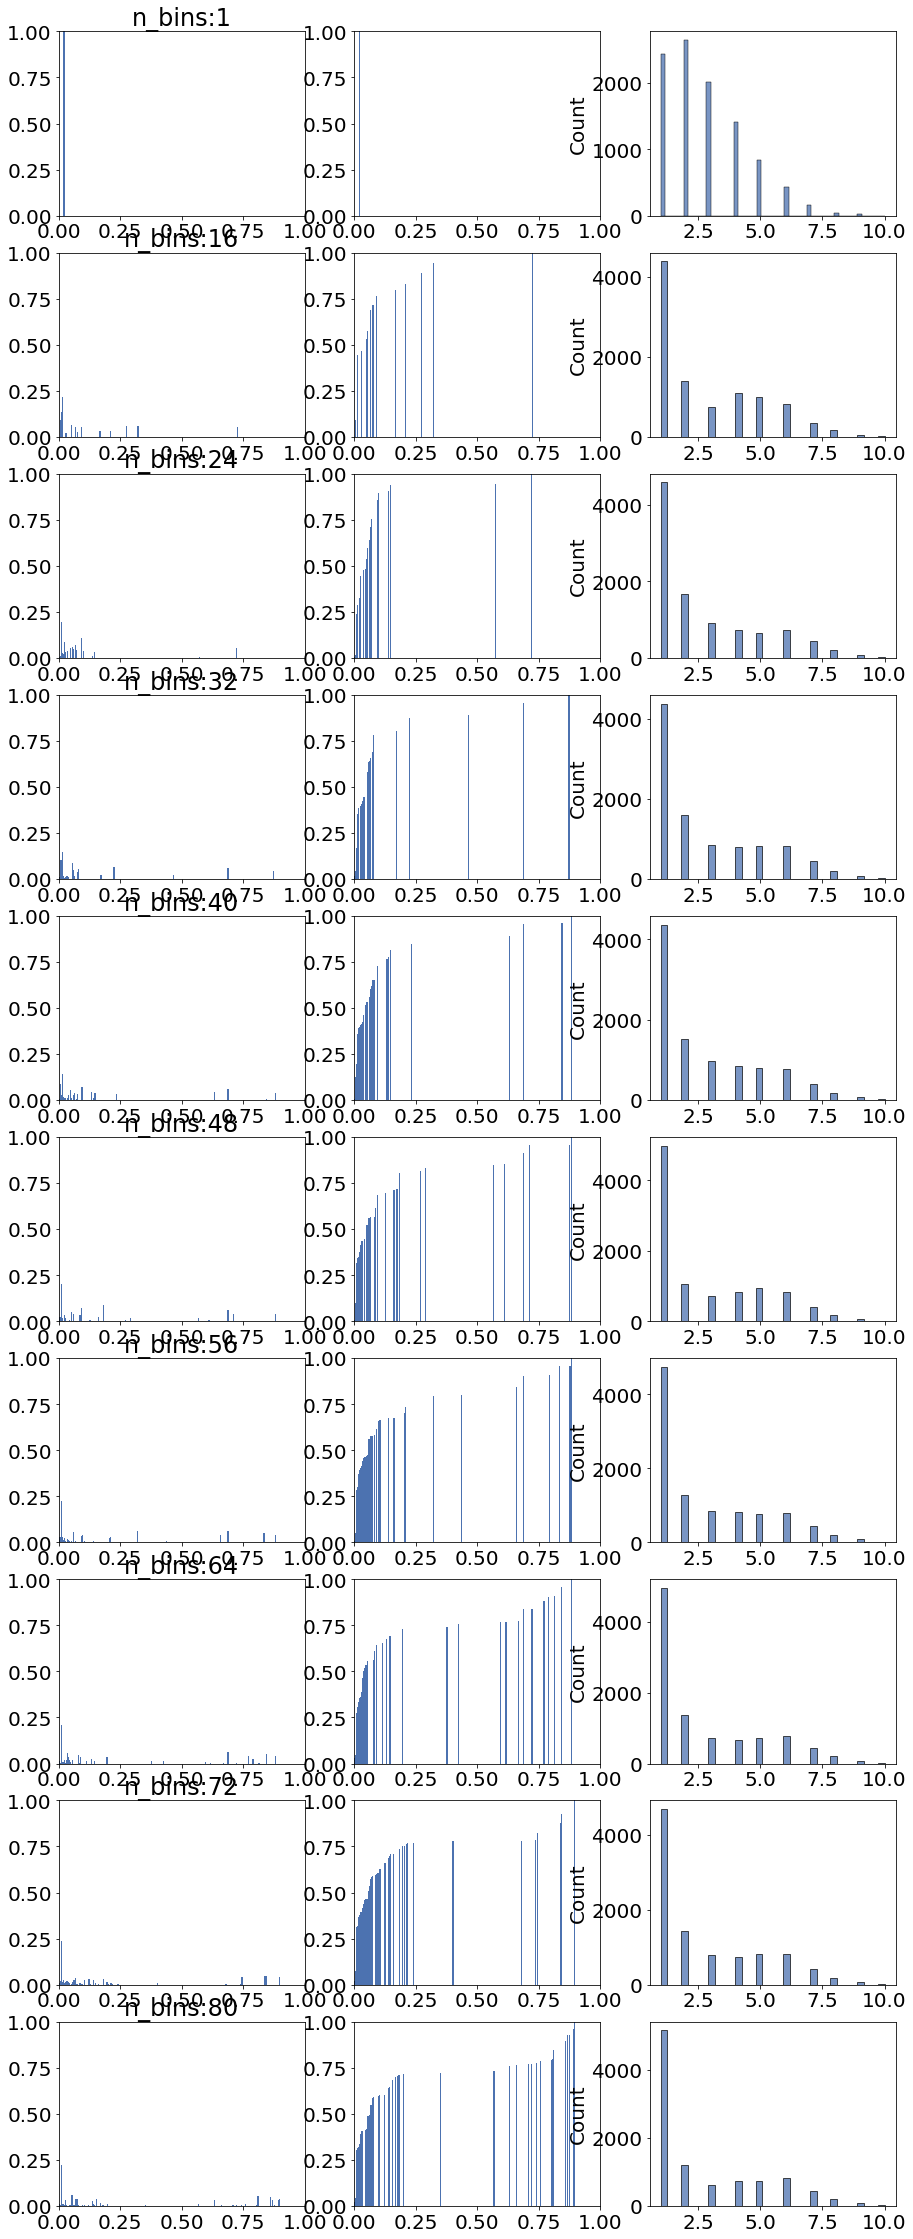

In [72]:
n_iter = 10

fig, axis = plt.subplots(n_iter,3, figsize=(15,n_iter*4))

c_gap  = 0*x_calib[:,0]

plot_stat = []
calib_stat=[]
test_stat = []
for it in range(n_iter ):
    print(it)
    tree_model, membership = tree_membership(z_calib, c_gap, 
                                             max_depth=20,
                                             max_leaf_nodes=(it+1)*8,
                                             min_samples_leaf=100)
    bin_idx, bin_counts = np.unique(membership, return_counts=True)
    dists = error *0 
    q_set = {}
    
    for idx in bin_idx:
        #idx_counter +=1
        #indices[membership==idx] = idx_counter
        
        error_subset = error[membership==idx]
        q = np.quantile(error_subset, Q)
        dists[membership==idx]=q-error_subset
        #print((membership==idx).sum())
        q_set.update({idx:q})
        #print({idx:q})
    
    A_conf,E_T,Co_F,Ms,Ones, C_sizes = tester(tree_model, calib_loader,q_set,net,
                             preprocess=lambda x: net(x).detach().cpu()) 
    calib_stat.append([A_conf,E_T,Co_F,Ms,Ones])
    
    A_conf,E_T,Co_F,Ms,Ones, C_sizes = tester(tree_model, test_loader,q_set,net,
                             preprocess=lambda x: net(x).detach().cpu())
    test_stat.append([A_conf,E_T,Co_F,Ms,Ones])
    
    #A_conf,E_T,Co_F = tester(tree_model, test_loader,q_set,net,
    #                         preprocess=lambda x: net(x).detach().cpu())
    #test_stat.append([A_conf,E_T,Co_F])
    
    #visualization
    prob = bin_counts/sum(bin_counts)
    neg_q = np.array([1-x for bin_idx, x in q_set.items()])
    
    ax = axis[it,0]
    ax.bar(neg_q,prob , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(F"n_bins:{len(neg_q)}")
    
    order = neg_q.argsort()
    x_axis,y_axis = neg_q[order],np.cumsum(prob[order])
    ax = axis[it,1]
    ax.bar(x_axis,y_axis , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    ax = axis[it,2]
    sns.histplot(C_sizes, ax = ax)#, bw_method=.1)
    
    plot_stat.append([(neg_q,prob),(x_axis,y_axis),C_sizes])
    
    # update for the next iteration
    c_gap = dists
    #c_gap = q_global-error

In [73]:
calib_stat, test_stat

([[0.99, 2.83652, 0.17685561, 3.370743293832133, 0.22534],
  [0.98998, 2.87622, 0.16431762, 4.2072136752136755, 0.415],
  [0.98992, 2.7386, 0.15476537, 4.070971844420108, 0.43386],
  [0.99008, 2.84916, 0.16204564, 4.180639168874058, 0.41862],
  [0.99006, 2.81338, 0.15884931, 4.11010873666518, 0.41694],
  [0.9901, 2.78102, 0.15785047, 4.395135155743643, 0.47542],
  [0.99036, 2.78988, 0.15633278, 4.28201554936189, 0.45464],
  [0.99038, 2.7332, 0.15354224, 4.289803355857566, 0.47316],
  [0.9906, 2.79388, 0.15701252, 4.24907628776353, 0.44788],
  [0.99082, 2.7214, 0.15164597, 4.399154851704119, 0.49358]],
 [[0.9899, 2.7827, 0.17327107, 3.3561987840338356, 0.2434],
  [0.9901, 2.8096, 0.15963763, 4.220501868659904, 0.4381],
  [0.9896, 2.6793, 0.15058, 4.102919438285292, 0.4588],
  [0.9895, 2.7846, 0.1577484, 4.17940495278817, 0.4387],
  [0.9903, 2.7688, 0.15585643, 4.140625, 0.4368],
  [0.9892, 2.711, 0.15364453, 4.408366533864542, 0.498],
  [0.989, 2.736, 0.15273339, 4.298498954968649, 0.47

No handles with labels found to put in legend.


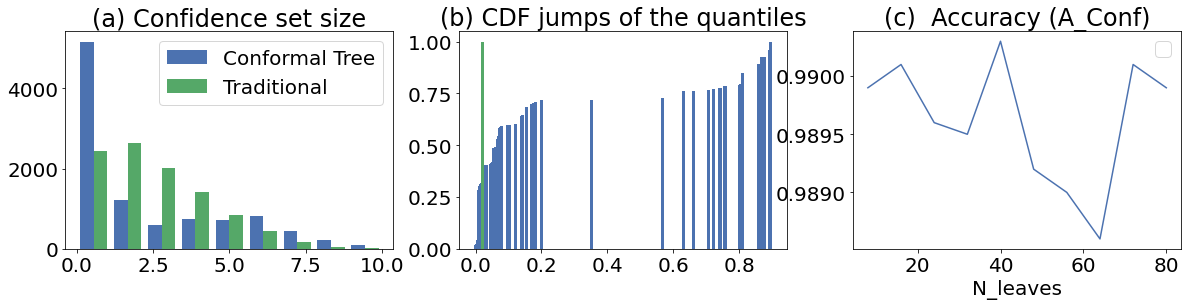

In [74]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')




fig, axis = plt.subplots(1,3, figsize=(20,4))

x = plot_stat[0][2].reshape(-1)
y = plot_stat[-1][2].reshape(-1)

ax=axis[0]
bins = np.linspace(0, 10, 10)
ax.hist([ y,x], bins, label=[ 'Conformal Tree','Traditional'])
ax.legend(loc='upper right')
ax.set_title("(a) Confidence set size")

ax = axis[1]
x = plot_stat[0][1]
y = plot_stat[-1][1]
ax.bar(*y , width=0.01,label='Conformal Tree')
ax.bar(*x , width=0.01,label='Traditional')
ax.set_title("(b) CDF jumps of the quantiles")
plt.legend(loc='upper right')

ax = axis[2]
x = [x[0] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
plt.plot(y,x)
ax.set_title("(c)  Accuracy (A_Conf)")
ax.set_xlabel("N_leaves")


plt.show()

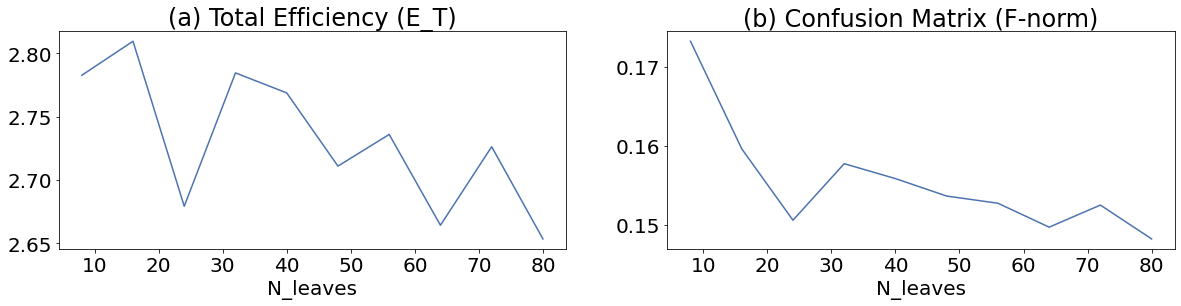

In [75]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')




fig, axis = plt.subplots(1,2, figsize=(20,4))

ax = axis[0]
x = [x[1] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
ax.plot(y,x)
ax.set_title("(a) Total Efficiency (E_T)")
ax.set_xlabel("N_leaves")


ax = axis[1]
x = [x[2] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
ax.plot(y,x)
ax.set_title("(b) Confusion Matrix (F-norm)")
ax.set_xlabel("N_leaves")


plt.show()

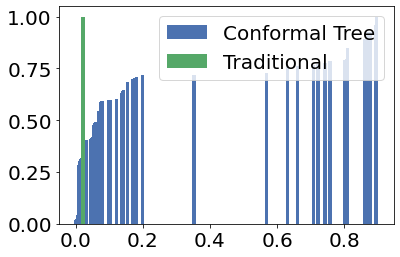

In [76]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')

x = plot_stat[0][1]
y = plot_stat[-1][1]
plt.bar(*y , width=0.01,label='Conformal Tree')
plt.bar(*x , width=0.01,label='Traditional')

#hist([x, y], bins, label=['Traditional', 'Conformal Tree'])
plt.legend(loc='upper right')
plt.show()

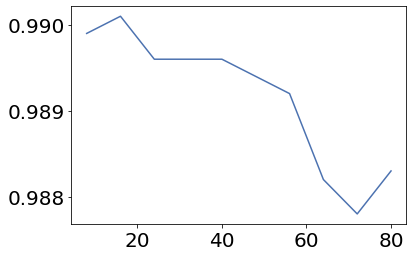

In [41]:
x = [x[0] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]

plt.plot(y,x)


